<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Another_copy_of_Untitled155.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1:
!pip uninstall -y qiskit qiskit-aer qiskit-aer-gpu qiskit-terra qiskit-ibm-runtime
!pip install qiskit==1.1.1 qiskit-aer-gpu==0.14.2 "tqdm"


Found existing installation: qiskit 1.1.1
Uninstalling qiskit-1.1.1:
  Successfully uninstalled qiskit-1.1.1
Found existing installation: qiskit-aer-gpu 0.14.2
Uninstalling qiskit-aer-gpu-0.14.2:
  Successfully uninstalled qiskit-aer-gpu-0.14.2
  Using cached qiskit-1.1.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached qiskit_aer_gpu-0.14.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
Using cached qiskit-1.1.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
Using cached qiskit_aer_gpu-0.14.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.8 MB)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- FRESH START selected. Starting a new run. ---
--- New Run ID 'qsim_2025-07-02_16-01-26' created. ---
QuantumRandomGenerator configured to use CPU for seeding.
Generating a quantum seed... (This may take a moment)
Quantum seed generated: 181646554

--- Starting New Quantum-Seeded Simulation ---


Simulating: 0it [00:00, ?it/s]


--- KNOCKOUT on day 3888: Cautious wins. ---


============ FINAL SIMULATION RESULT =============
Winner:                   Cautious
Duration (Days):          3888
Final Cautious:           10000
Final Reckless:           0


/tmp/ipython-input-1-4002622409.py:345: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()


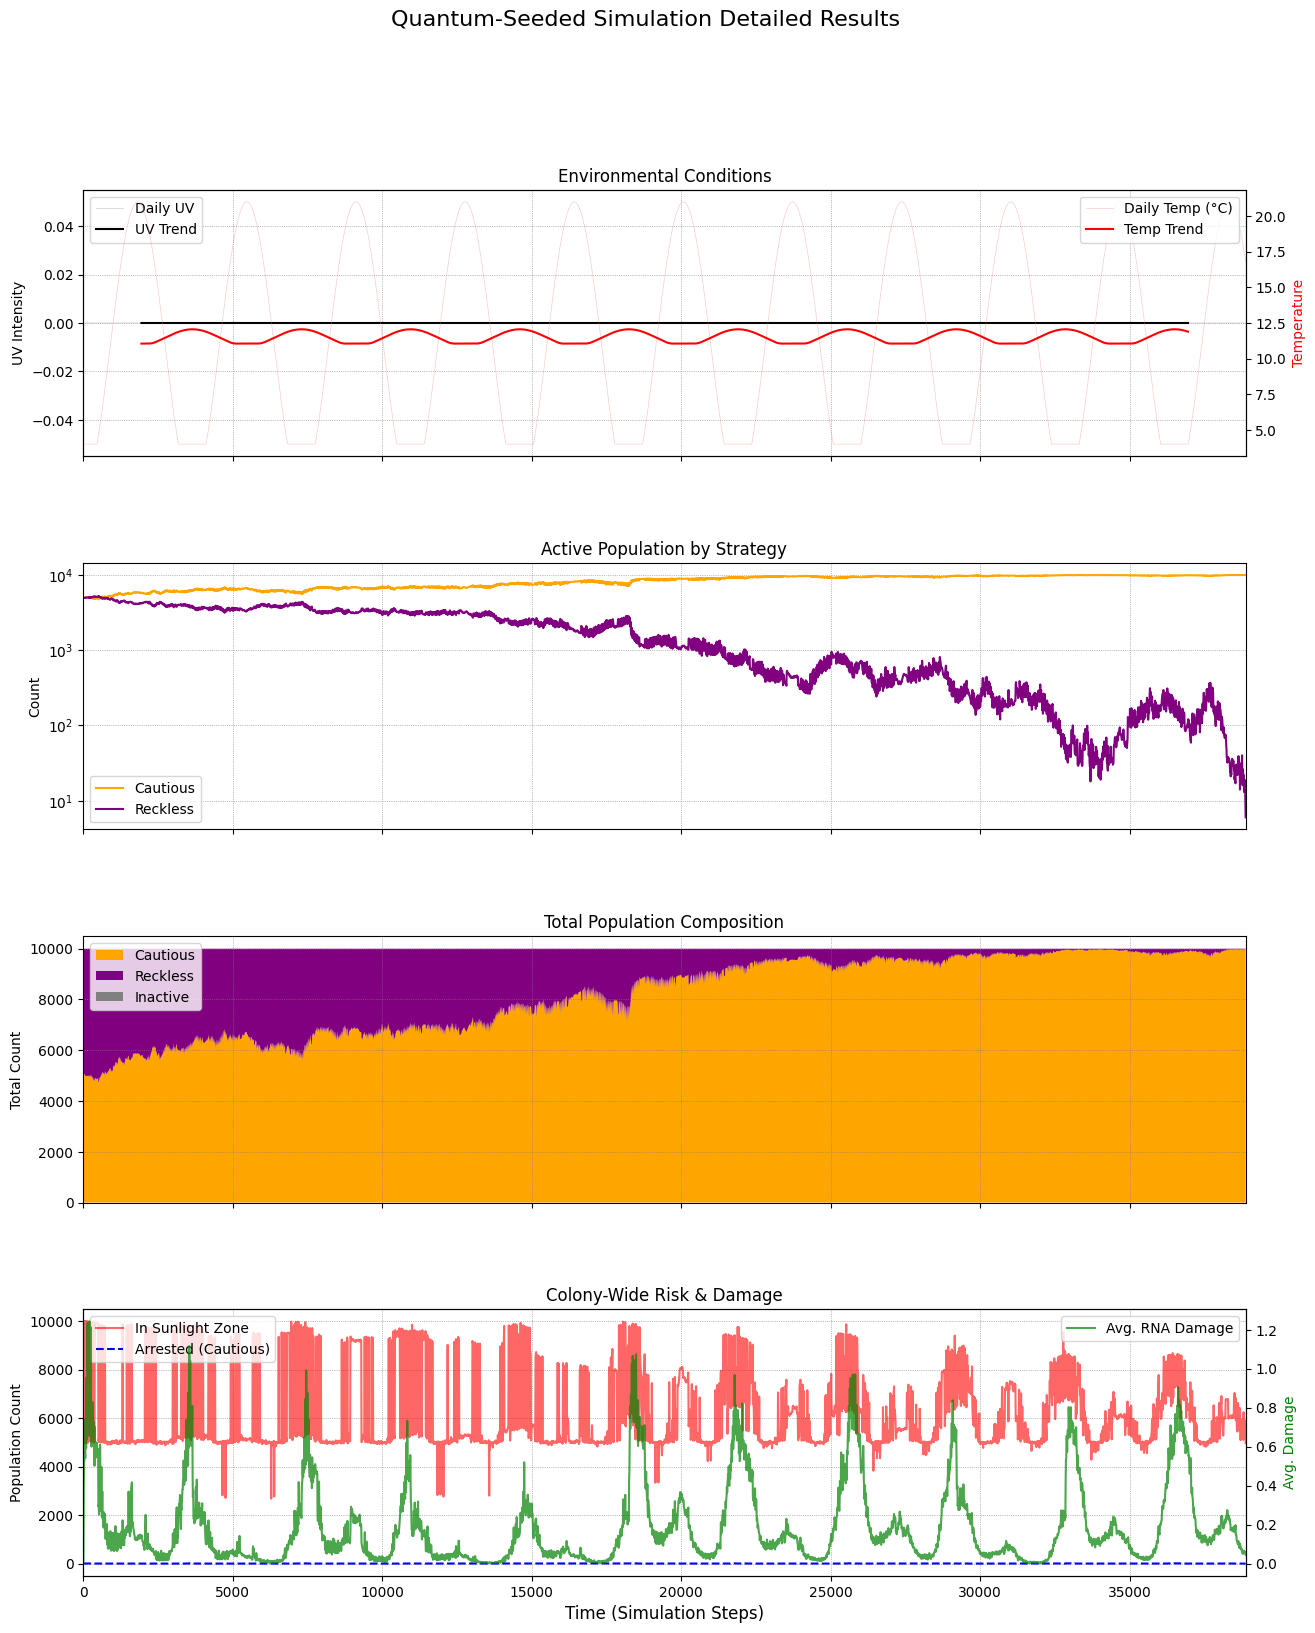

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import pickle

# ===== New & Required Imports =====
from datetime import datetime
from google.colab import output
from tqdm.notebook import tqdm

# ===== QISKIT IMPORTS =====
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# ===== GOOGLE DRIVE MOUNT =====
from google.colab import drive
drive.mount('/content/drive')


# ===== Quantum Random Number Generator Class (Used for Seeding) =====
class QuantumRandomGenerator:
    def __init__(self, num_bits_precision=64):
        self.simulator = AerSimulator()
        print("QuantumRandomGenerator configured to use CPU for seeding.")
        self.num_bits = num_bits_precision

    def get_seed(self):
        """Generates a single, high-quality random integer seed."""
        print("Generating a quantum seed... (This may take a moment)")
        circuit = QuantumCircuit(self.num_bits, self.num_bits)
        circuit.h(range(self.num_bits))
        circuit.measure(range(self.num_bits), range(self.num_bits))
        transpiled_circuit = transpile(circuit, self.simulator)
        job = self.simulator.run(transpiled_circuit, shots=1)
        result = job.result()
        counts = result.get_counts(0)
        bit_string = list(counts.keys())[0]
        seed = int(bit_string, 2)
        print(f"Quantum seed generated: {seed}")
        return seed

# --- 1. Environment Class ---
class Environment:
    def __init__(self, rng, days_per_cycle=50):
        self.days_per_cycle, self.time, self.rng = days_per_cycle, 0, rng
        self.steps_per_year = 365 * self.days_per_cycle
        self.uv_intensity, self.temperature, self.yearly_uv_severity = self._generate_cycles(num_years=50)

    def _generate_cycles(self, num_years):
        daily_uv_cycle = np.sin(np.linspace(0, 2 * np.pi, self.days_per_cycle)); daily_uv_cycle[daily_uv_cycle < 0] = 0
        daily_temp_swing = -4 * np.cos(np.linspace(0, 2 * np.pi, self.days_per_cycle))
        full_uv, full_temp, yearly_severity_log = [], [], []

        for _ in range(num_years):
            uv_severity = self.rng.uniform(0.6, 1.4)
            yearly_severity_log.extend([uv_severity] * self.steps_per_year)
            seasonal_cycle = np.sin(np.linspace(0, 2 * np.pi, self.steps_per_year))
            seasonal_temp_base = 15 - 10 * np.cos(np.linspace(0, 2 * np.pi, self.steps_per_year))
            seasonal_amplitude_mod = (0.225 * seasonal_cycle + 0.725) * uv_severity
            GEOTHERMAL_BASE_TEMP = 4.0
            year_temp = []

            for i in range(self.steps_per_year):
                # ✅ ADDED: Daily random fluctuation for "cloud cover"
                cloud_cover_factor = self.rng.uniform(0.7, 1.0)

                # Calculate temperature for the step
                solar_temp = seasonal_temp_base[i] + daily_temp_swing[i % self.days_per_cycle]
                year_temp.append(max(GEOTHERMAL_BASE_TEMP, solar_temp))

                # Calculate UV for the step
                daily_uv = daily_uv_cycle[i % self.days_per_cycle]
                seasonal_uv = daily_uv * seasonal_amplitude_mod[i]
                final_uv = seasonal_uv * cloud_cover_factor
                full_uv.append(final_uv)

            full_temp.extend(year_temp)
        return np.array(full_uv), np.array(full_temp), np.array(yearly_severity_log)

    def get_current_uv(self): return self.uv_intensity[self.time % len(self.uv_intensity)]
    def get_current_temperature(self): return self.temperature[self.time % len(self.temperature)]
    def get_current_uv_severity(self): return self.yearly_uv_severity[self.time % len(self.yearly_uv_severity)]
    def step(self): self.time += 1

# --- 2. Protoribosome Class ---
class Protoribosome:
    def __init__(self, env, strategy, initial_sequence, rng, initial_mass=100.0):
        self.env, self.strategy, self.rna_sequence, self.rng = env, strategy, list(initial_sequence), rng
        self.rna_mass, self.atp_pool, self.mcyw_peptide_pool, self.other_peptide_pool = initial_mass, 500.0, 50.0, 5.0
        self.rna_damage_level, self.location, self.status, self.metabolic_efficiency = 0.0, 'shadow_zone', 'ACTIVE', 1.0
        self.uv_damage_rate_per_uv, self.repair_rate = 1.2, 0.5
        self.uv_protection_factor, self.damage_tolerance_threshold = 0.01, 3.0
        self.atp_generation_rate_per_mcyw_uv, self.baseline_atp_chemosynthesis, self.protein_synthesis_rate = 0.15, 1.5, 0.20
        self.replication_rate, self.atp_degradation_rate, self.mutation_prob = 0.05, 0.025, 0.004
        self.growth_rate, self.optimal_temp, self.temp_tolerance = 0.1, 25.0, 15.0
    def get_peptide_type(self):
        codons = ["".join(self.rna_sequence[i:i+3]) for i in range(0, len(self.rna_sequence), 3)]
        return "MCYW" if any(c in {'UGU', 'UGC', 'UAU', 'UAC', 'UGG'} for c in codons) else "XXXX"
    def has_stop_codon(self): return any(c in {'UAA', 'UAG', 'UGA'} for c in ["".join(self.rna_sequence[i:i+3]) for i in range(0, len(self.rna_sequence), 3)])
    def _decide_zone_transition(self):
        if self.location == 'shadow_zone' and self.atp_pool < 450: self.location = 'sunlight_zone'
        elif self.location == 'sunlight_zone' and self.rna_damage_level > self.damage_tolerance_threshold * 0.75: self.location = 'shadow_zone'
    def _apply_uv_damage(self, current_uv):
        if self.location == 'shadow_zone' or current_uv <= 0:
            self.rna_damage_level = max(0, self.rna_damage_level - self.repair_rate * 0.1)
            return
        protection = self.mcyw_peptide_pool * self.uv_protection_factor
        effective_uv = current_uv * max(0.01, 1 - protection)
        self.rna_damage_level += effective_uv * self.uv_damage_rate_per_uv
        for i in range(len(self.rna_sequence)):
            if self.rng.random() < self.mutation_prob * effective_uv: self.rna_sequence[i] = self.rng.choice(list("AUGC"))
    def _manage_state(self, has_stop_codon_cached):
        if self.atp_pool < 0.1 or self.rna_damage_level >= self.damage_tolerance_threshold: self.status = 'INACTIVE'; return
        if self.strategy == 'cautious' and has_stop_codon_cached: self.status = 'ARRESTED'
        elif self.status == 'ARRESTED' and not has_stop_codon_cached: self.status = 'ACTIVE'
        self.metabolic_efficiency = 1.25 if self.status == 'ACTIVE' else 1.0
    def _synthesize_protein(self, has_stop_codon_cached, temp_factor):
        if self.status != 'ACTIVE': return
        if self.strategy == 'readthrough' and has_stop_codon_cached: self.status = 'INACTIVE'; return
        units = self.protein_synthesis_rate * self.metabolic_efficiency * temp_factor * 10
        if self.get_peptide_type() == "MCYW": self.mcyw_peptide_pool += units
        else: self.other_peptide_pool += units
        self.atp_pool -= units * 0.02
    def _replicate_rna(self, temp_factor):
        if self.status != 'ACTIVE' or self.rna_mass < 80: return None
        can_replicate = self.rna_mass * self.replication_rate * self.metabolic_efficiency * temp_factor
        if self.atp_pool > can_replicate * 0.2:
            offspring_mass = self.rna_mass * 0.5
            self.rna_mass -= offspring_mass
            self.atp_pool -= can_replicate * 0.2
            return Protoribosome(self.env, self.strategy, "".join(self.rna_sequence), self.rng, offspring_mass)
        return None
    def _repair_rna_dna(self, dna_template, temp_factor):
        if self.strategy == 'readthrough': return
        repair_efficiency = temp_factor
        if self.status == 'ARRESTED': repair_efficiency *= 0.2
        elif self.status != 'ACTIVE': return
        if "".join(self.rna_sequence) != dna_template:
            for i in range(len(self.rna_sequence)):
                if self.rna_sequence[i] != dna_template[i]:
                    if self.rng.random() < repair_efficiency:
                        if self.atp_pool > 0.0025:
                            self.atp_pool -= 0.0025; self.rna_sequence[i] = dna_template[i]
                            self.rna_damage_level = max(0, self.rna_damage_level - self.repair_rate)
                    break
    def _grow_mass(self, temp_factor):
        if self.status != 'ACTIVE': return
        potential_growth = self.rna_mass * self.growth_rate * self.metabolic_efficiency * temp_factor
        self.rna_mass += potential_growth
        self.atp_pool -= potential_growth * 0.1
    def step(self, current_uv, current_temp, dna_template):
        if self.status == 'INACTIVE': return None
        if current_temp < 10: temp_factor = 0.2 + ((current_temp - 5) / 5.0) * 0.8; temp_factor = max(0.2, temp_factor)
        elif current_temp > 22: heat_penalty = (current_temp - 22) / 6.0; temp_factor = max(0.1, 1.0 - heat_penalty)
        else: temp_factor = 1.0
        self._decide_zone_transition(); self._apply_uv_damage(current_uv); self._repair_rna_dna(dna_template, temp_factor)
        has_stop = self.has_stop_codon()
        self._manage_state(has_stop)
        if self.status == 'INACTIVE': return None
        self.atp_pool += self.baseline_atp_chemosynthesis; self.atp_pool *= (1 - self.atp_degradation_rate)
        if self.location == 'sunlight_zone' and current_uv > 0:
            photosynthesis_gain = self.atp_generation_rate_per_mcyw_uv * self.mcyw_peptide_pool * current_uv
            if current_temp > 18: photosynthesis_gain *= 1.5
            self.atp_pool += photosynthesis_gain
        self._grow_mass(temp_factor); self. _synthesize_protein(has_stop, temp_factor)
        if self.status == 'INACTIVE': return None
        return self._replicate_rna(temp_factor)

# --- 3. Colony Class ---
class Colony:
    def __init__(self, env, dna_template, initial_pop_size, steps_per_day, rng, shuffle_rng):
        self.env, self.dna_template, self.steps_per_day, self.max_population = env, dna_template, steps_per_day, 10000
        self.rng, self.shuffle_rng = rng, shuffle_rng
        self.active_population = [Protoribosome(env, 'cautious' if i%2==0 else 'readthrough', dna_template, rng) for i in range(initial_pop_size)]
        self.inactive_population = []
    def step(self, current_step):
        current_uv, current_temp = self.env.get_current_uv(), self.env.get_current_temperature()
        if current_step > 0 and current_step % self.steps_per_day == 0: self.inactive_population.clear()
        next_generation = []
        for protoribosome in self.active_population:
            new_offspring = protoribosome.step(current_uv, current_temp, self.dna_template)
            if protoribosome.status != 'INACTIVE': next_generation.append(protoribosome)
            else: self.inactive_population.append(protoribosome)
            if new_offspring: next_generation.append(new_offspring)
        self.active_population = next_generation
        if len(self.active_population) > self.max_population:
            self.shuffle_rng.shuffle(self.active_population)
            self.active_population = self.active_population[:self.max_population]

    def get_aggregated_data(self):
        data = { 'cautious': 0, 'readthrough': 0, 'arrested': 0, 'inactive': 0, 'in_sunlight_zone': 0, 'avg_damage': 0.0 }
        if not self.active_population:
            data['inactive'] = len(self.inactive_population)
            return data
        for p in self.active_population:
            if p.strategy == 'cautious':
                data['cautious'] += 1
                if p.status == 'ARRESTED': data['arrested'] += 1
            else: data['readthrough'] += 1
            if p.location == 'sunlight_zone': data['in_sunlight_zone'] += 1
            data['avg_damage'] += p.rna_damage_level
        if len(self.active_population) > 0: data['avg_damage'] /= len(self.active_population)
        data['inactive'] = len(self.inactive_population)
        return data

    def get_genetic_load_analysis(self):
        cautious_total, cautious_with_stop = 0, 0
        reckless_total, reckless_with_stop = 0, 0
        for p in self.active_population:
            has_stop = p.has_stop_codon()
            if p.strategy == 'cautious':
                cautious_total += 1
                if has_stop: cautious_with_stop += 1
            else:
                reckless_total += 1
                if has_stop: reckless_with_stop += 1
        cautious_stop_pct = (cautious_with_stop / cautious_total * 100) if cautious_total > 0 else 0
        reckless_stop_pct = (reckless_with_stop / reckless_total * 100) if reckless_total > 0 else 0
        return cautious_total, cautious_stop_pct, reckless_total, reckless_stop_pct

# --- 4. Simulation Runner ---
def run_single_simulation(steps_per_day, rng, shuffle_rng, save_path):
    if os.path.exists(save_path):
        print(f"--- Resuming simulation from {os.path.basename(os.path.dirname(save_path))} ---")
        with open(save_path, 'rb') as f: saved_state = pickle.load(f)
        colony, start_step, data_log = saved_state['colony'], saved_state['step_count'], saved_state['log']
        colony.env.time = start_step
    else:
        print(f"\n--- Starting New Quantum-Seeded Simulation ---")
        start_step, data_log = 0, []
        IDEAL_DNA_TEMPLATE = "AUGUGUUACUGG"
        env = Environment(rng, days_per_cycle=steps_per_day)
        colony = Colony(env, IDEAL_DNA_TEMPLATE, initial_pop_size=5000, steps_per_day=steps_per_day, rng=rng, shuffle_rng=shuffle_rng)

    progress_bar = tqdm(desc="Simulating", initial=start_step)
    step_count = start_step
    winner = "Unknown"

    postfix_dict = {'Status': 'Running...'}
    progress_bar.set_postfix(postfix_dict)

    while True:
        # Extinction check
        if step_count > 1000:
            agg_data = colony.get_aggregated_data()
            cautious_pop = agg_data.get('cautious', 0)
            reckless_pop = agg_data.get('readthrough', 0)
            cautious_extinct = (cautious_pop == 0)
            reckless_extinct = (reckless_pop == 0)

            if cautious_extinct and reckless_extinct:
                winner = "Mutual Extinction"; break
            elif cautious_extinct:
                winner = "Reckless"; break
            elif reckless_extinct:
                winner = "Cautious"; break

        colony.step(step_count)

        # ✅ Log data once per day
        if step_count > 0 and step_count % steps_per_day == 0:
            agg_data = colony.get_aggregated_data()
            log_entry = {'time': colony.env.time, 'uv': colony.env.get_current_uv(), 'temp': colony.env.get_current_temperature()}
            log_entry['uv_severity'] = colony.env.get_current_uv_severity()
            log_entry.update(agg_data)
            data_log.append(log_entry)

        colony.env.step()
        progress_bar.update(1)

        # Occasional status update
        if step_count % 250 == 0:
            cautious_pop, cautious_stop_pct, reckless_pop, reckless_stop_pct = colony.get_genetic_load_analysis()
            postfix_dict.update({
                'Cautious': f"{cautious_pop} ({cautious_stop_pct:.1f}% stop)",
                'Reckless': f"{reckless_pop} ({reckless_stop_pct:.1f}% stop)"
            })
            progress_bar.set_postfix(postfix_dict)

        # Save state
        if step_count > 0 and step_count % 500 == 0:
            postfix_dict['Status'] = 'Saving...'
            progress_bar.set_postfix(postfix_dict)
            temp_save_path = save_path + ".tmp"
            state_to_save = {'step_count': step_count, 'colony': colony, 'log': data_log}
            with open(temp_save_path, 'wb') as f: pickle.dump(state_to_save, f)
            os.replace(temp_save_path, save_path)
            postfix_dict['Status'] = 'Running...'
            progress_bar.set_postfix(postfix_dict)

        step_count += 1

    progress_bar.close()
    final_day = (step_count -1) // steps_per_day
    print(f"\n--- KNOCKOUT on day {final_day}: {winner} wins. ---")
    results_df = pd.DataFrame(data_log)
    summary = { 'Winner': winner, 'Duration (Days)': final_day, 'Final Cautious': colony.get_aggregated_data().get('cautious', 0), 'Final Reckless': colony.get_aggregated_data().get('readthrough', 0) }
    return summary, results_df

# --- 5. Plotting Function ---
def plot_simulation_details(results_df):
    if results_df.empty: print("No data to plot."); return
    fig, axs = plt.subplots(4, 1, figsize=(15, 18), sharex=True, gridspec_kw={'hspace': 0.4})
    fig.suptitle('Quantum-Seeded Simulation Detailed Results', fontsize=16)
    colors = {'cautious': 'orange', 'readthrough': 'purple', 'inactive': 'grey'}

    # ✅ Panel 1: Plotting the full run to show seasonal trends
    ax0_twin = axs[0].twinx()
    # Using thin, semi-transparent lines to create the "band" effect for daily data
    axs[0].plot(results_df['time'], results_df['uv'], color='gray', alpha=0.4, label='Daily UV', lw=0.5)
    ax0_twin.plot(results_df['time'], results_df['temp'], color='lightcoral', alpha=0.4, label='Daily Temp (°C)', lw=0.5)

    # Overlay a rolling average to show the seasonal trend clearly
    rolling_window = len(results_df) // 10 # Adjust window for more or less smoothing
    if rolling_window > 0:
      axs[0].plot(results_df['time'], results_df['uv'].rolling(window=rolling_window, center=True).mean(), color='black', label='UV Trend', lw=1.5)
      ax0_twin.plot(results_df['time'], results_df['temp'].rolling(window=rolling_window, center=True).mean(), color='red', label='Temp Trend', lw=1.5)

    axs[0].set_title('Environmental Conditions'); axs[0].set_ylabel('UV Intensity'); ax0_twin.set_ylabel('Temperature', color='r')
    axs[0].legend(loc='upper left'); ax0_twin.legend(loc='upper right')

    # Panel 2: Population Dynamics
    axs[1].plot(results_df['time'], results_df['cautious'], label='Cautious', color=colors['cautious'])
    axs[1].plot(results_df['time'], results_df['readthrough'], label='Reckless', color=colors['readthrough'])
    axs[1].set_title('Active Population by Strategy'); axs[1].set_ylabel('Count'); axs[1].legend(); axs[1].set_yscale('symlog')

    # Panel 3: Population Composition
    axs[2].stackplot(results_df['time'], results_df.get('cautious', 0), results_df.get('readthrough', 0), results_df.get('inactive', 0), labels=['Cautious', 'Reckless', 'Inactive'], colors=[colors['cautious'], colors['readthrough'], colors['inactive']])
    axs[2].set_title('Total Population Composition'); axs[2].set_ylabel('Total Count'); axs[2].legend(loc='upper left')

    # Panel 4: Risk Analysis
    ax3_twin = axs[3].twinx()
    axs[3].plot(results_df['time'], results_df.get('in_sunlight_zone', 0), label='In Sunlight Zone', color='red', alpha=0.6)
    axs[3].plot(results_df['time'], results_df.get('arrested', 0), label='Arrested (Cautious)', color='blue', linestyle='--')
    ax3_twin.plot(results_df['time'], results_df.get('avg_damage', 0), label='Avg. RNA Damage', color='green', alpha=0.7)
    axs[3].set_title('Colony-Wide Risk & Damage'); axs[3].set_ylabel('Population Count'); ax3_twin.set_ylabel('Avg. Damage', color='g')
    axs[3].legend(loc='upper left'); ax3_twin.legend(loc='upper right')

    # General Formatting
    for ax in axs: ax.grid(True, linestyle=':', linewidth='0.5', color='gray')
    if not results_df.empty: axs[3].set_xlabel("Time (Simulation Steps)", fontsize=12); ax.set_xlim(left=0, right=results_df['time'].max())
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

# --- 6. Main Orchestrator ---
def main():
    CHOSEN_ACTION = 'fresh_start'

    BASE_SAVE_DIR = os.path.join('/content/drive/My Drive/Colab Notebooks/Sim_Saves/')
    os.makedirs(BASE_SAVE_DIR, exist_ok=True)

    save_dir_to_use = None
    run_id = None

    if CHOSEN_ACTION == 'resume':
        all_runs = sorted([d for d in os.listdir(BASE_SAVE_DIR) if os.path.isdir(os.path.join(BASE_SAVE_DIR, d))])
        if all_runs:
            run_id = all_runs[-1]
            save_dir_to_use = os.path.join(BASE_SAVE_DIR, run_id)
            print(f"--- RESUME selected. Found latest run. Resuming Run ID: {run_id} ---")
        else:
            print("--- RESUME selected, but no runs found. Starting a fresh run instead. ---")
            CHOSEN_ACTION = 'fresh_start'

    if CHOSEN_ACTION == 'fresh_start':
        if run_id is None:
             print("--- FRESH START selected. Starting a new run. ---")
        try:
            notebook_name = output.eval_js('google.colab.kernel.notebook.getName()').replace('.ipynb', '')
        except Exception:
            notebook_name = "qsim"
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        run_id = f"{notebook_name}_{timestamp}"
        save_dir_to_use = os.path.join(BASE_SAVE_DIR, run_id)
        os.makedirs(save_dir_to_use, exist_ok=True)
        print(f"--- New Run ID '{run_id}' created. ---")

    SAVE_FILE_PATH = os.path.join(save_dir_to_use, 'simulation_state.pkl')
    STEPS_PER_DAY = 10

    seed_file_path = os.path.join(save_dir_to_use, 'quantum_seed.txt')
    if not os.path.exists(SAVE_FILE_PATH):
        q_rng = QuantumRandomGenerator(num_bits_precision=29)
        quantum_seed = q_rng.get_seed()
        with open(seed_file_path, 'w') as f:
            f.write(str(quantum_seed))
    else:
        print("--- Loading existing quantum seed for this run. ---")
        with open(seed_file_path, 'r') as f:
            quantum_seed = int(f.read())
        print(f"Loaded seed: {quantum_seed}")

    shuffle_rng = random.Random(quantum_seed)
    sim_rng = np.random.default_rng(seed=quantum_seed)

    summary, details_df = run_single_simulation(steps_per_day=STEPS_PER_DAY, rng=sim_rng, shuffle_rng=shuffle_rng, save_path=SAVE_FILE_PATH)

    title = " FINAL SIMULATION RESULT "
    width = 50
    print("\n\n" + "="*width)
    print(title.center(width, "="))
    print("="*width)
    for key, value in summary.items():
        print(f"{key+':':<25} {value}")
    print("="*width)

    plot_simulation_details(details_df)

if __name__ == "__main__":
    main()
